Reference: [BERT NLP guide](https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
sys.path += ['/content/drive/Shareddrive/filtered_data']
%cd /content/drive/Shareddrives/cs145project/filtered_data/stocks
%cd ../..
%cd headlines/sentiment_analysis_financial_news
path="all-data.csv"
df=pd.read_csv(path,encoding = "ISO-8859-1",header=None)
df.columns = ['Sentiment','Text']

Mounted at /content/drive
/content/drive/Shareddrives/cs145project/filtered_data/stocks
/content/drive/Shareddrives/cs145project
/content/drive/Shareddrives/cs145project/headlines/sentiment_analysis_financial_news


In [ ]:

df.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
pos = 0
neg = 0
neutral = 0
for index, row in df.iterrows():
  if row['Sentiment'] == 'positive':
    pos+=1
  elif row['Sentiment'] == 'negative':
    neg+=1
  else:
    neutral+=1

In [ ]:
print(f"pos count: {pos}")
print(f"neg count: {neg}")
print(f"neutral count: {neutral}")

pos count: 1363
neg count: 604
neutral count: 2879


In [ ]:
def to_sentiment(score):
  score = str(score)
  if score == 'negative':
    return 0
  elif score == 'neutral':
    return 1
  else:
    return 2
df['Sentiment'] = df.Sentiment.apply(to_sentiment)

In [ ]:
df.head()

,Sentiment,Text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")


In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
token_lens = []

# Iterate through the content slide
for txt in df.Text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

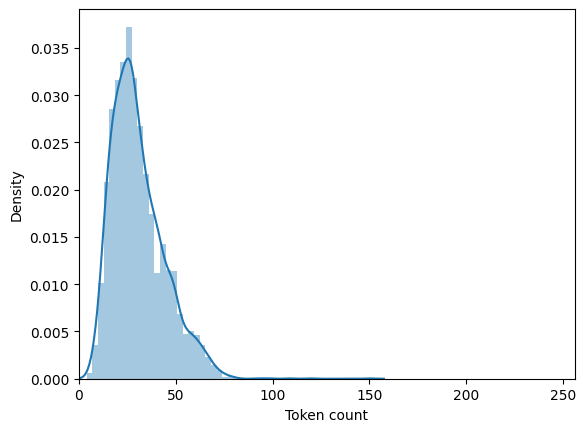

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 120

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# get train, test, and validation dataset
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=0)

print(df_train.shape, df_val.shape, df_test.shape)

(3876, 2) (485, 2) (485, 2)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Text.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 120])
torch.Size([16, 120])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased',return_dict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)


768


In [ ]:
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.5576932305171166 accuracy 0.7757997936016512
Val   loss 0.3461319539816149 accuracy 0.8701030927835052

Epoch 2/3
----------
Train loss 0.24580470511475155 accuracy 0.9125386996904025
Val   loss 0.4222656542495374 accuracy 0.8721649484536083

Epoch 3/3
----------
Train loss 0.13214259519943117 accuracy 0.9620743034055728
Val   loss 0.4699308995998675 accuracy 0.8845360824742268

CPU times: user 2h 40min 31s, sys: 45.5 s, total: 2h 41min 17s
Wall time: 2h 42min 3s


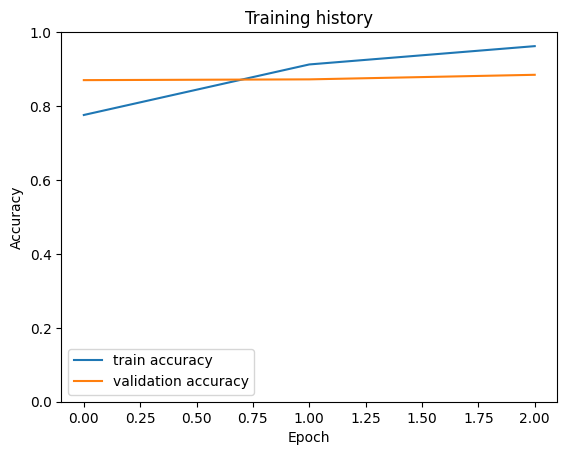

In [ ]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# model = torch.load('best_model_state.bin')
model = SentimentClassifier(len(class_names))
model = model.to(device)
model.load_state_dict(torch.load('best_model_state.bin'))
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
type(model)

__main__.SentimentClassifier

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8350515463917526

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.81      0.82      0.82        62
     neutral       0.87      0.87      0.87       292
    positive       0.77      0.77      0.77       131

    accuracy                           0.84       485
   macro avg       0.82      0.82      0.82       485
weighted avg       0.84      0.84      0.84       485



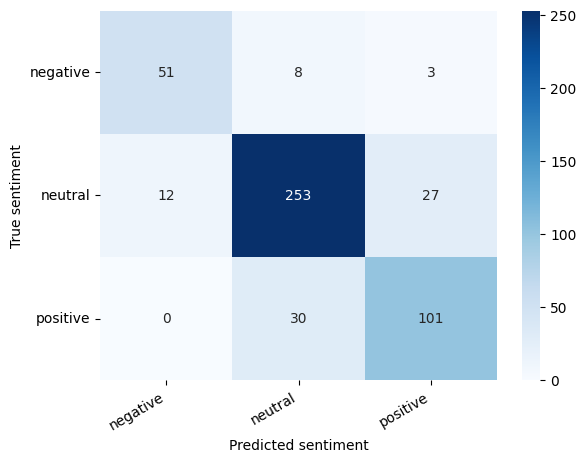

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


In [ ]:
%cd /content/drive/Shareddrives/cs145project/filtered_data/

/content/drive/Shareddrives/cs145project/filtered_data


In [ ]:
path="top-50-analyst-ratings-processed.csv"
headlines=pd.read_csv(path,encoding = "ISO-8859-1")
headlines.head()

,title,date,stock
0,"Piper Sandler Maintains Overweight on Adobe, L...",2020-03-31 06:18:00-04:00,ADBE
1,Shares of several technology companies are tra...,2020-03-30 10:23:00-04:00,ADBE
2,"Shares of several technology, semiconductor an...",2020-03-27 11:30:00-04:00,ADBE
3,"Cramer Reveals Stock Favorites, Says Intuitive...",2020-03-27 10:10:00-04:00,ADBE
4,Shares of several software companies are tradi...,2020-03-26 10:38:00-04:00,ADBE


In [ ]:
headlines.shape[0]

116993

In [ ]:
headlines = headlines.assign(sentiment = '' * headlines.shape[0])

In [ ]:
headlines.shape

(116993, 4)

In [ ]:
headlines

,title,date,stock,sentiment
0,"Piper Sandler Maintains Overweight on Adobe, L...",2020-03-31 06:18:00-04:00,ADBE,
1,Shares of several technology companies are tra...,2020-03-30 10:23:00-04:00,ADBE,
2,"Shares of several technology, semiconductor an...",2020-03-27 11:30:00-04:00,ADBE,
3,"Cramer Reveals Stock Favorites, Says Intuitive...",2020-03-27 10:10:00-04:00,ADBE,
4,Shares of several software companies are tradi...,2020-03-26 10:38:00-04:00,ADBE,
...,...,...,...,...
116988,Bank of America Up Better Than 4%,2012-01-05 12:17:00-05:00,WFC,
116989,New Fed Transparency Buys Time For The Stock M...,2012-01-03 15:55:00-05:00,WFC,
116990,Will GE Make You Money in 2012?,2012-01-03 13:38:00-05:00,WFC,
116991,Best Utilities Stocks of 2011,2011-12-28 12:17:00-05:00,WFC,


In [ ]:
for index,row in headlines.iterrows():
  review_text = row['title']
  encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  row['sentiment'] = class_names[prediction]

  if (index % 1000) == 0:
    print(f"On row: {index}")

On row: 0
On row: 1000
On row: 2000
On row: 3000
On row: 4000
On row: 5000
On row: 6000
On row: 7000
On row: 8000
On row: 9000
On row: 10000
On row: 11000
On row: 12000
On row: 13000
On row: 14000
On row: 15000
On row: 16000
On row: 17000
On row: 18000
On row: 19000
On row: 20000
On row: 21000
On row: 22000
On row: 23000
On row: 24000
On row: 25000
On row: 26000
On row: 27000
On row: 28000
On row: 29000
On row: 30000
On row: 31000
On row: 32000
On row: 33000
On row: 34000
On row: 35000
On row: 36000
On row: 37000
On row: 38000
On row: 39000
On row: 40000
On row: 41000
On row: 42000
On row: 43000
On row: 44000
On row: 45000
On row: 46000
On row: 47000
On row: 48000
On row: 49000
On row: 50000
On row: 51000
On row: 52000
On row: 53000
On row: 54000
On row: 55000
On row: 56000
On row: 57000
On row: 58000
On row: 59000
On row: 60000
On row: 61000
On row: 62000
On row: 63000
On row: 64000
On row: 65000
On row: 66000
On row: 67000
On row: 68000
On row: 69000
On row: 70000
On row: 71000
On ro

In [ ]:
headlines.to_pickle("bert_sentiment.pkl")

In [ ]:
import numpy as np
import pandas as pd
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
sys.path += ['/content/drive/Shareddrive/filtered_data']
%cd /content/drive/Shareddrives/cs145project/filtered_data/stocks
%cd ../..
%cd headlines/sentiment_analysis_financial_news
%cd /content/drive/Shareddrives/cs145project/filtered_data/
df = pd.read_pickle("bert_sentiment.pkl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/cs145project/filtered_data/stocks
/content/drive/Shareddrives/cs145project
/content/drive/Shareddrives/cs145project/headlines/sentiment_analysis_financial_news
/content/drive/Shareddrives/cs145project/filtered_data


In [ ]:
df.describe()

,title,date,stock,sentiment
count,116993,116993,116993,116993
unique,93149,95163,50,3
top,Benzinga's Top Upgrades,2020-03-12 12:10:00-04:00,MRK,neutral
freq,374,27,3232,76039


In [ ]:
pos = 0
neg = 0
neutral = 0
for index, row in df.iterrows():
  if row['sentiment'] == 'positive':
    pos+=1
  elif row['sentiment'] == 'negative':
    neg+=1
  else:
    neutral+=1
print(f"pos count: {pos}")
print(f"neg count: {neg}")
print(f"neutral count: {neutral}")
print(f"pos %: {pos/df.shape[0]*100}")
print(f"neg %: {neg/df.shape[0]*100}")
print(f"neutral %: {neutral/df.shape[0]*100}")

pos count: 22853
neg count: 18101
neutral count: 76039
pos %: 19.533647312232354
neg %: 15.471865838127066
neutral %: 64.99448684964058
